In [25]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses05M_impro07_F028,5,all dudes ?
1,Ses04F_script03_1_M002,3,it must be them then .
2,Ses03M_impro05b_F012,5,for tonight for tonight sir . would you need t...
3,Ses01F_impro07_F003,1,oh i know i know i know i know .
4,Ses04F_script03_2_F030,0,why ?


In [26]:
col = ['label', 'transcription']
df = df[col]

In [27]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [28]:
df.columns = ['label', 'transcription']

In [29]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

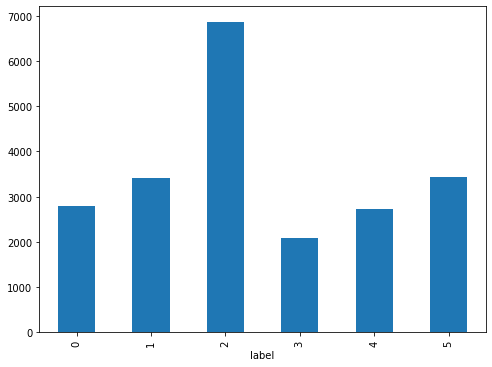

In [30]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(21316, 4504)


In [31]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [32]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [33]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int

KeyboardInterrupt: 

Test Set Accuracy =  0.579
Test Set F-score =  0.574
Test Set Precision =  0.783
Test Set Recall =  0.520
Confusion matrix, without normalization
[[ 177   13  385    0    3    7]
 [   2  258  400    9   12   16]
 [  23   22 1276    4    9   42]
 [   0    0  136  259    0    0]
 [  10    0  205    0  322    0]
 [   7    8  473    4    4  178]]


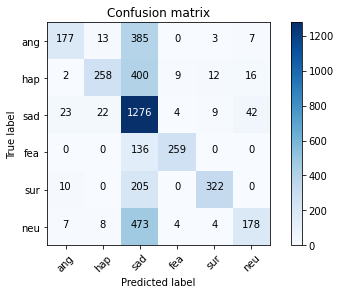

In [13]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.755
Test Set F-score =  0.748
Test Set Precision =  0.756
Test Set Recall =  0.765
Confusion matrix, without normalization
[[ 419    5   73   54    6   28]
 [  12  526   53   34   26   46]
 [  66   28 1073   77   33   99]
 [   0    0    9  386    0    0]
 [   1    0    1  129  406    0]
 [  28   43  139   37   18  409]]


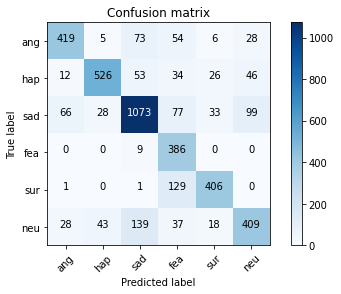

In [14]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.670
Test Set F-score =  0.674
Test Set Precision =  0.766
Test Set Recall =  0.628
Confusion matrix, without normalization
[[ 293    6  237    0   10   39]
 [   6  457  155   12   18   49]
 [  55   29 1198    4   16   74]
 [   0    0  150  239    6    0]
 [   0    0  166    0  371    0]
 [  23   45  291    8    8  299]]


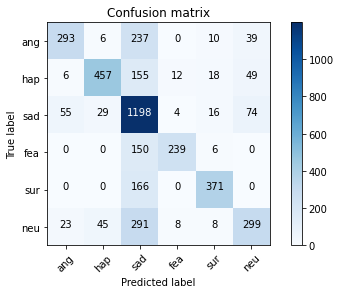

In [15]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.778
Test Set F-score =  0.769
Test Set Precision =  0.780
Test Set Recall =  0.784
Confusion matrix, without normalization
[[ 442    2   60   54    6   21]
 [  12  533   46   33   23   50]
 [  46   21 1120   78   32   79]
 [   0    0    9  386    0    0]
 [   1    3    1  129  403    0]
 [  28   35  126   37   15  433]]


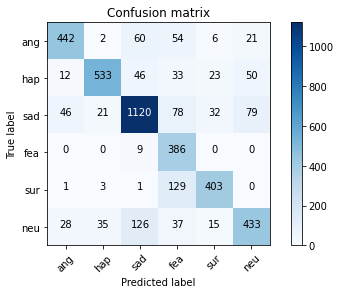

In [16]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.714
Test Set F-score =  0.720
Test Set Precision =  0.775
Test Set Recall =  0.687
Confusion matrix, without normalization
[[ 345    3  182    6    9   40]
 [   6  508   89   16   25   53]
 [  50   30 1159    4   34   99]
 [   0    0  131  264    0    0]
 [   1    1  130    0  405    0]
 [  22   50  217    7   16  362]]


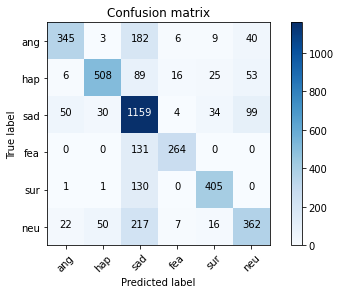

In [17]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

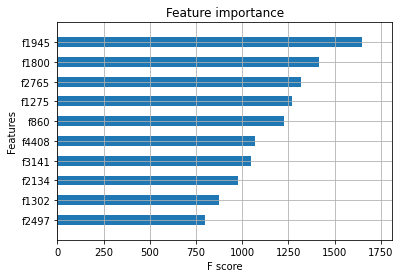

In [22]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [18]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Test Set Accuracy =  0.225
Test Set F-score =  0.144
Test Set Precision =  0.178
Test Set Recall =  0.167
Confusion matrix, without normalization
[[ 86  83 293 117   3  14]
 [100  78 346 139   3  23]
 [215 186 687 225   9  32]
 [ 67  59 202  84   0  17]
 [ 73  73 255  93   5  29]
 [100  93 342 110   3  20]]


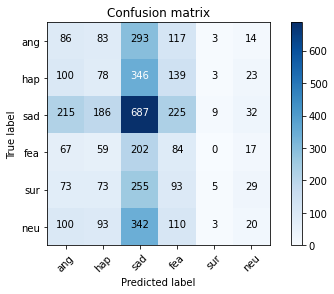

In [35]:
with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)
    
display_results(y_test, lstm_pred_probs)

Test Set Accuracy =  0.761
Test Set F-score =  0.766
Test Set Precision =  0.823
Test Set Recall =  0.731
Confusion matrix, without normalization
[[ 408    3  141    5    6   22]
 [   7  527   84   13   21   45]
 [  39   13 1227    4   29   64]
 [   0    0  131  264    0    0]
 [   1    4  130    0  402    0]
 [  15   36  185    5   14  419]]


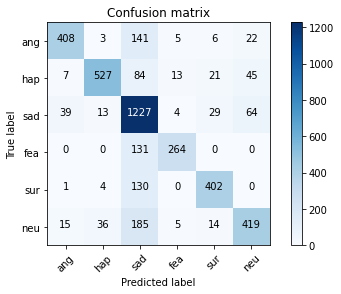

In [20]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

In [21]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 500 features:
Test Set Accuracy =  0.579
Test Set F-score =  0.575
Test Set Precision =  0.782
Test Set Recall =  0.520
Stats for top 1000 features:
Test Set Accuracy =  0.579
Test Set F-score =  0.574
Test Set Precision =  0.783
Test Set Recall =  0.520
Stats for top 1500 features:
Test Set Accuracy =  0.579
Test Set F-score =  0.574
Test Set Precision =  0.783
Test Set Recall =  0.520
Stats for top 2000 features:
Test Set Accuracy =  0.579
Test Set F-score =  0.574
Test Set Precision =  0.783
Test Set Recall =  0.520
